In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('lateky')

In [2]:
import jax.numpy as jnp
from jax import jacfwd

def standardmap(xy, K):
    ynew = xy[1] - K*jnp.sin(2*jnp.pi*xy[0])/(2*jnp.pi)
    xnew = jnp.mod(xy[0] + ynew, 1)
    return jnp.array([xnew, ynew])

def reversedmap(xy, K):
    xold = jnp.mod(xy[0] - xy[1], 1)
    yold = xy[1] + K*jnp.sin(2*jnp.pi*xold)/(2*jnp.pi)
    return jnp.array([xold, yold])

from jax import jit
jitedmap = jit(standardmap, static_argnums=1)
jitedreversed = jit(reversedmap, static_argnums=1)

# def standardmap(x, y, K=1.2):
#     ynew = np.mod(y + K*np.sin(x), 2*np.pi)
#     xnew = np.mod(x + ynew, 2*np.pi)
#     return xnew, ynew

In [3]:
dstandardmap = jacfwd(standardmap)
jiteddmap = jit(dstandardmap, static_argnums=1)

In [26]:
xi = np.linspace(0., 1, 30)
yi = np.linspace(0.5, 1.5, 15)
# xi = np.linspace(0., 2*np.pi, 10)
Xi = np.meshgrid(xi, yi)
Xi = np.vstack((Xi[0].flatten(), Xi[1].flatten())).T
# Xi = np.vstack((np.linspace(0., 1, 10), np.linspace(0., 1, 10))).T


In [27]:
nev = 200
Ev = np.empty(((nev,)+Xi.shape))
Ev[0] = Xi

In [28]:
Ev.shape

(200, 450, 2)

In [29]:
K = 0.97

In [30]:
for i in range(1, Ev.shape[0]):
    evolved = np.array([jitedmap(Ev[i-1,j,:], K) for j in range(Ev.shape[1])])
    Ev[i,:,:] = evolved

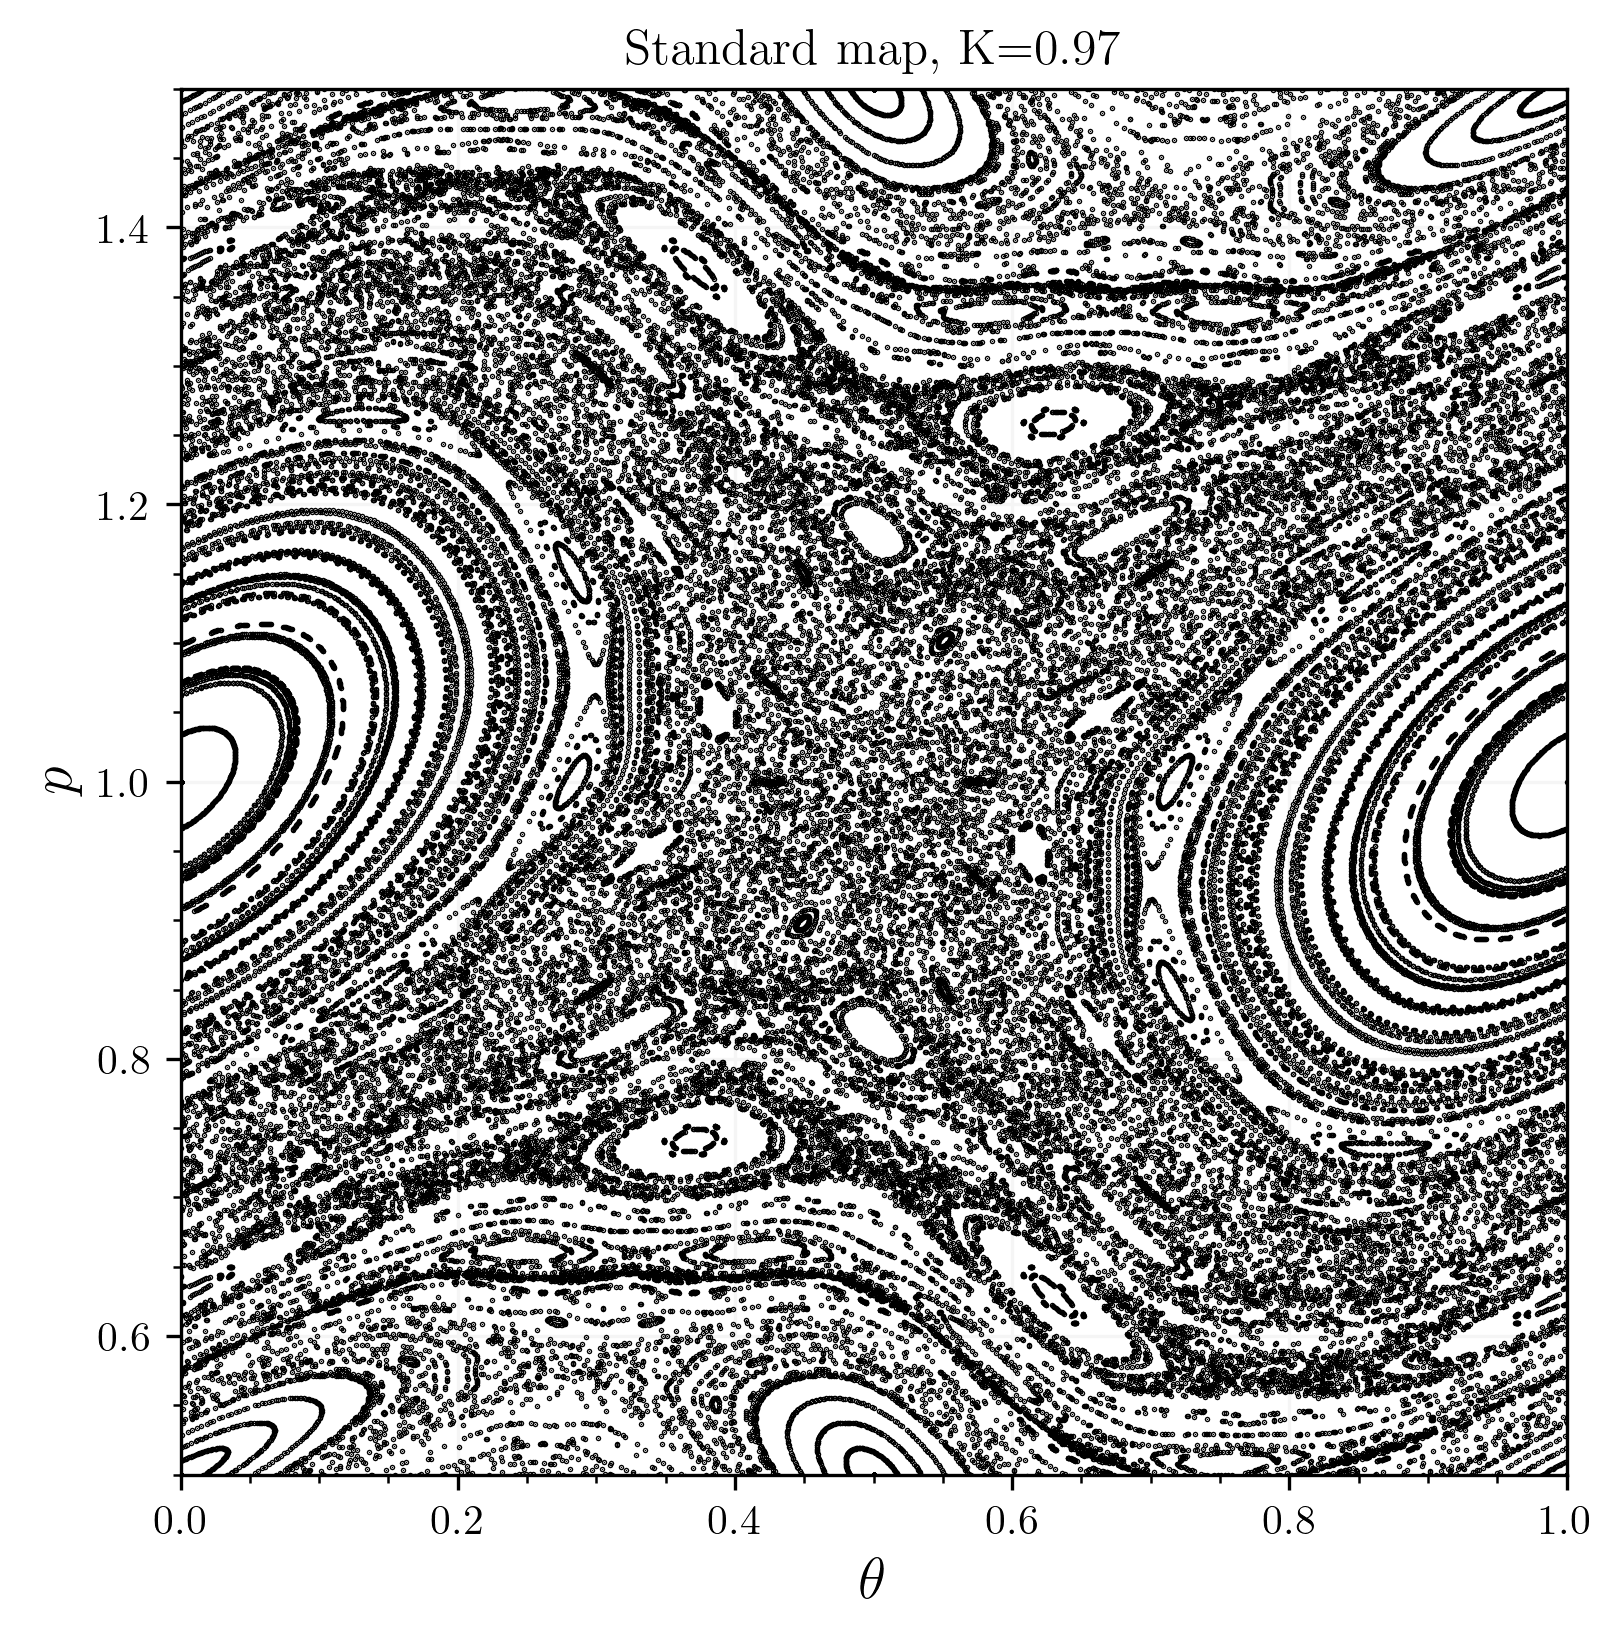

In [52]:
fig, ax = plt.subplots(dpi=300)
ax.set_title(f'Standard map, K={K}')
ax.set_xlabel(r'$\theta$', fontsize=14)
ax.set_ylabel(r'$p$', fontsize=14)
ax.set_aspect('equal')
ax.set_xlim(0, 1)
ax.set_ylim(0.5, 1.5)
fig.set_size_inches(6, 6)


for i in range(len(Ev[0,:,0])):
    ax.scatter(Ev[:, i, 0], Ev[:, i, 1], s=0.1, zorder = 10, c='black')
# ax.axis('off')

In [32]:
path = '../../presentation/images'

In [33]:
from scipy.optimize import root

def fixedpoint(xy, m=1):
    xyev = xy
    while m > 0:
        xyev = jitedmap(xyev, K)
        m -= 1

    return xy -xyev

In [34]:
sol = root(fixedpoint, [0.5, 0.5])

In [35]:
sol.x

array([0.5       , 1.00000001])

In [36]:
jacobian = jiteddmap(jnp.array([0.5, 1.]), K)

In [37]:
ax.scatter(sol.x[0], sol.x[1], marker='X', c='blue', zorder=10)

In [38]:
def eig(jacobian):
    """Compute the eigenvalues and eigenvectors of the jacobian and returns them in the order : stable, unstable."""
    eigRes = np.linalg.eig(jacobian)
    eigenvalues = np.abs(eigRes[0])

    # Eigenvectors are stored as columns of the matrix eigRes[1], transposing it to access them as np.array[i]
    eigenvectors = eigRes[1].T
    s_index, u_index = 0, 1
    if eigenvalues[0].real > eigenvalues[1].real:
        s_index, u_index = 1, 0

    return (
        eigenvalues[s_index],
        eigenvectors[s_index],
        eigenvalues[u_index],
        eigenvectors[u_index],
    )

In [39]:
def start_config(epsilon, rfp, eigenvalue, eigenvector, map, neps=10):
    # Initial point and evolution
    rEps = rfp + epsilon * eigenvector
    rz_path = map(rEps, K=K)

    # Direction of the evolution
    eps_dir = rz_path - rEps 
    norm_eps_dir = np.linalg.norm(eps_dir)
    eps_dir_norm = eps_dir / norm_eps_dir

    # Geometric progression from log_eigenvalue(epsilon) to log_eigenvalue(epsilon + norm_eps_dir)
    eps = np.logspace(
        np.log(epsilon) / np.log(eigenvalue),
        np.log(epsilon + norm_eps_dir) / np.log(eigenvalue),
        neps,
        base=eigenvalue,
    )

    Rs = rfp[0] + eps * eps_dir_norm[0]
    Zs = rfp[1] + eps * eps_dir_norm[1]
    RZs = np.array([[r, z] for r, z in zip(Rs, Zs)])

    return RZs

In [40]:
lambda_s, v_s, lambda_u, v_u = eig(jacobian)

In [41]:
lambda_s, v_s, lambda_u, v_u

(0.3871726,
 array([-0.53411496,  0.84541184], dtype=float32),
 2.5828273,
 array([0.8526301 , 0.52251506], dtype=float32))

In [42]:
lambda_s * lambda_u

1.0

In [43]:
def evolve(startconfig, nintersect, map):
    startconfig = np.atleast_2d(startconfig)
    rz_path = np.zeros((2 * startconfig.shape[0], nintersect + 1))
    rz_path[:, 0] = startconfig.flatten()

    for i, rz in enumerate(startconfig):
        ic = rz

        for j in range(nintersect):
            output = map(ic, K=K)
            ic = output
            rz_path[2 * i, j + 1] = output[0]
            rz_path[2 * i + 1, j + 1] = output[1]

    return rz_path

In [44]:
Nint = 18
neps = 800

In [58]:
msize = 3

In [59]:
startconfig = start_config(1e-6, sol.x, lambda_u, v_u, jitedmap, neps=neps)
path = evolve(startconfig, Nint, jitedmap)
out = path.T.flatten()
ax.plot(
    out[::2],
    out[1::2],
    '.',
    markersize=msize,
    c='r', zorder=20)

In [60]:
startconfig = start_config(1e-6, sol.x, lambda_u, -v_u, jitedmap, neps=neps)
path = evolve(startconfig, Nint, jitedmap)
out = path.T.flatten()
ax.plot(
    out[::2],
    out[1::2],
    '.',
    markersize=msize,
    c='r', zorder=20)

In [61]:
startconfig = start_config(1e-6, sol.x, lambda_s, v_s, jitedreversed, neps=neps)
path = evolve(startconfig, Nint, jitedreversed)
out = path.T.flatten()
ax.plot(
    out[::2],
    out[1::2],
    '.',
    markersize=msize,
    c='g', zorder=20)

In [62]:
startconfig = start_config(1e-6, sol.x, lambda_s, -v_s, jitedreversed, neps=neps)
path = evolve(startconfig, Nint, jitedreversed)
out = path.T.flatten()
ax.plot(
    out[::2],
    out[1::2],
    '.',
    markersize=msize,
    c='g', zorder=20)

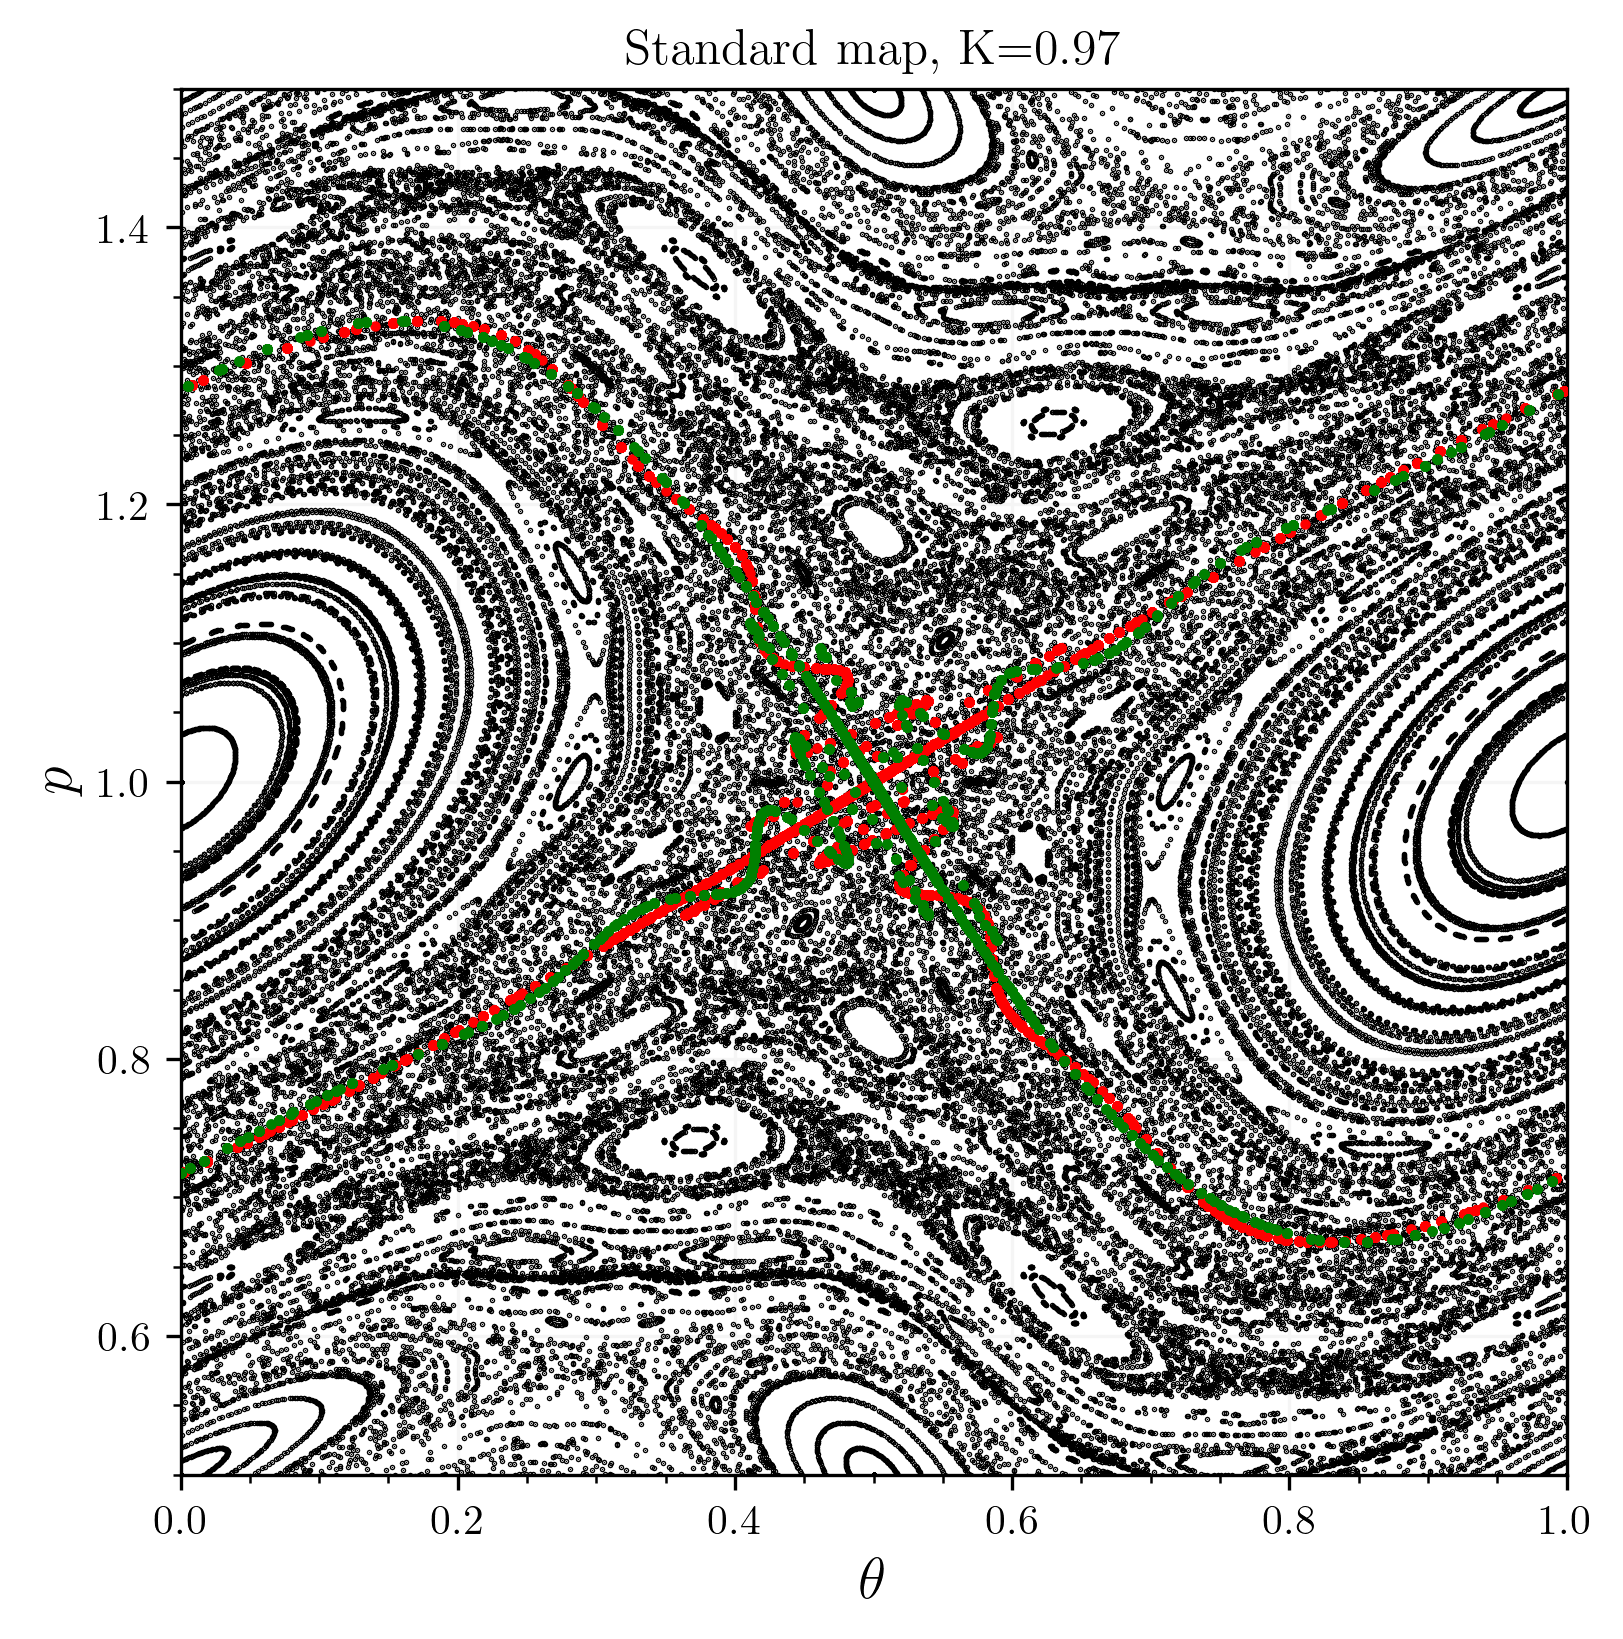

In [63]:
fig